In [40]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle
from sklearn. metrics import classification_report, roc_auc_score, roc_curve

In [2]:
df = pd.read_csv("shopee_final.csv", encoding="utf-8", index_col=0)

In [15]:
df.shape

(900874, 2)

In [3]:
df.head()

,processed_text,class
0,miếng dán hơi_dầy không_thẩm,neutral
1,miếng dán rất_tồi bóc bụi giải_quyết thỏa_đáng...,neutral
2,cường_lực trắng màu đen,negative
3,hàng cảm_quan đầu mặt xước dã dán chiều tối xư...,negative
4,chất_lượng cường_lực chống trộm không_như quản...,negative


### Check NAN again

In [6]:
print('Data shape:', df.shape)
missing_val_num = df.isnull().sum()
missing_percent = (missing_val_num / df.shape[0]) * 100
missing_info = {'missing_values': missing_val_num,
                'missing_percent': round(missing_percent,3)}
missing_df = pd.DataFrame(missing_info)
missing_df

Data shape: (934543, 2)


,missing_values,missing_percent
processed_text,33669,3.603
class,0,0.000


In [14]:
# Drop all rows with NaN values
df.dropna(inplace=True)
print(df.shape)
print(df.isnull().sum())

(900874, 2)
processed_text    0
class             0
dtype: int64


### Duplicate Data

In [16]:
# Display duplicate rows
print('Duplicate data:', df.duplicated().sum())
df[df.duplicated()]

Duplicate data: 367513


,processed_text,class
132,hàng,negative
188,hàng,negative
243,hỏng,negative
282,hàng,negative
386,hàng,neutral
...,...,...
934527,chất_lượng sản_phẩm kém,negative
934528,hình_ảnh ví_dụ không_liên quan thái_độ làm_ăn ...,negative
934533,chất_lượng sản_phẩm tạm,neutral
934534,chất_lượng sản_phẩm,negative


In [17]:
# Drop all duplicate rows
df.drop_duplicates(inplace=True)
print('Duplicate data:', df.duplicated().sum())
print(df.shape)
# Reset index
df.reset_index(drop=True, inplace=True)

Duplicate data: 0
(533361, 2)


In [19]:
df['class'].value_counts()

positive    313718
negative    138271
neutral      81372
Name: class, dtype: int64

### TF-IDF Vectorizer

In [20]:
# Create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.02)

In [21]:
# Fit the TfidfVectorizer object to the data
x = tfidf_vectorizer.fit(df['processed_text'].values.astype('U'))

In [22]:
# Transform the data
X = tfidf_vectorizer.transform(df['processed_text'].values.astype('U'))

In [23]:
### BUG: 
# This is probably because you are using an older scikit-learn version than the one this code was written for.
# get_feature_names_out is a method of the class sklearn.feature_extraction.text.TfidfVectorizer since scikit-learn 1.0. Previously, there was a similar method called get_feature_names.
# So you should update your scikit-learn package, or use the old method (not recommended).
# Create a new dataframe with the transformed data
df_new = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [24]:
df_new.head()

,bé,chuẩn,chất,chất vải,chất_liệu,chất_lượng,chất_lượng sản_phẩm,cũng_không,cẩn_thận,dày_dặn,...,đóng_gói,đường,đầu,đẹp,đẹp lắm,đồ,đổi,ảnh,ổn,ủng_hộ
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.510192,0.0,0.0,0.0,0.0,...,0.0,0.0,0.789106,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.638299,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
y = df['class']

In [27]:
print(X.shape, y.shape)

(533361, 60) (533361,)


### Cross Validation

In [30]:
# Choose 0.3, 0.2 as the test size
test_size_list = [.3, .2]
# Run 5 times for each test_size
for test_size in test_size_list:
  print('Test size: ', test_size)
  accuracy_train_list = []
  accuracy_test_list = []
  for i in range(5):
    print('Run: ', i)
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    # Create a LogisticReg (for faster training)
    clf = LogisticRegression()
    # Train the classifier
    clf.fit(X_train, y_train)
    # Make predictions
    y_pred = clf.predict(X_test)
    # Calculate the accuracy
    accuracy_train = accuracy_score(y_train, clf.predict(X_train))
    accuracy_test = accuracy_score(y_test, y_pred)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)
  print('Test size: ', test_size, ' Train accuracy: ', sum(accuracy_train_list) / len(accuracy_train_list), ' Test accuracy: ',
      sum(accuracy_test_list) / len(accuracy_test_list))
  print('--------------------------------------------------')

Test size:  0.3
Run:  0
Run:  1
Run:  2
Run:  3
Run:  4
Test size:  0.3  Train accuracy:  0.652027577192569  Test accuracy:  0.6514121080689211
--------------------------------------------------
Test size:  0.2
Run:  0
Run:  1
Run:  2
Run:  3
Run:  4
Test size:  0.2  Train accuracy:  0.6518889680515974  Test accuracy:  0.6516306844281121
--------------------------------------------------


- test size 0.2 vẫn tốt hơn môt chút, nhưng không đáng kể

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Model Comparision

In [36]:
models = [
    RandomForestClassifier(n_estimators=50),
    RandomForestClassifier(n_estimators=100),
    KNeighborsClassifier(n_neighbors=3),
    KNeighborsClassifier(n_neighbors=5),
    KNeighborsClassifier(n_neighbors=7),
    LogisticRegression(multi_class='multinomial')
    
]

In [38]:
def get_model_name(model):
  model_name = model.__class__.__name__
  if model_name == 'KNeighborsClassifier':
    model_name = model_name + '_' + str(model.n_neighbors)
  elif model_name == 'RandomForestClassifier':
    model_name = model_name + '_' + str(model.n_estimators)
    
  return model_name

In [41]:
# Number of folds for cross validation
num_folds = 5
# A dataframe to store the results
results = pd.DataFrame(columns=['Model', 'Accuracy Mean', 'Accuracy 3 * STD', 'Time'])
# Integrate through models
for model in models:
  # Get model name
  model_name = get_model_name(model)  
  print('Model: ', model_name, 'running...')
  # Get the current time
  start_time = datetime.now()  
  # Perform cross validation
  cv_results = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='accuracy', n_jobs=-1)  
  # Get the training time
  train_time = datetime.now() - start_time  
  # Get the mean and std of the results
  mean_cv_results = cv_results.mean()
  std_cv_results = cv_results.std()  
  # Store the results
  results = results.append({'Model': model_name,
                            'Accuracy Mean': mean_cv_results,
                            'Accuracy 3 * STD': 3 * std_cv_results,
                            'Time': train_time
                            }, ignore_index=True)

Model:  RandomForestClassifier_50 running...


/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/ipykernel_5862/3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  RandomForestClassifier_100 running...


/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/ipykernel_5862/3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  KNeighborsClassifier_3 running...


/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/ipykernel_5862/3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  KNeighborsClassifier_5 running...


/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/ipykernel_5862/3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  KNeighborsClassifier_7 running...


/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/ipykernel_5862/3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  LogisticRegression running...


/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/ipykernel_5862/3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


### Metric result

In [42]:
# Sort the dataframe by Accuracy Mean in descending order
results = results.sort_values(by='Accuracy Mean', ascending=False).reset_index(drop=True)
results

,Model,Accuracy Mean,Accuracy 3 * STD,Time
0,LogisticRegression,0.652631,0.002586,0 days 00:00:06.942273
1,RandomForestClassifier_100,0.644772,0.002520,0 days 00:10:54.732153
2,RandomForestClassifier_50,0.643615,0.002528,0 days 00:05:53.232980
3,KNeighborsClassifier_7,0.621786,0.004605,0 days 00:10:13.584122
4,KNeighborsClassifier_5,0.612318,0.003843,0 days 00:10:33.516121
5,KNeighborsClassifier_3,0.600535,0.004940,0 days 00:10:23.524123


Text(0.5, 1.0, 'Model Comparison')

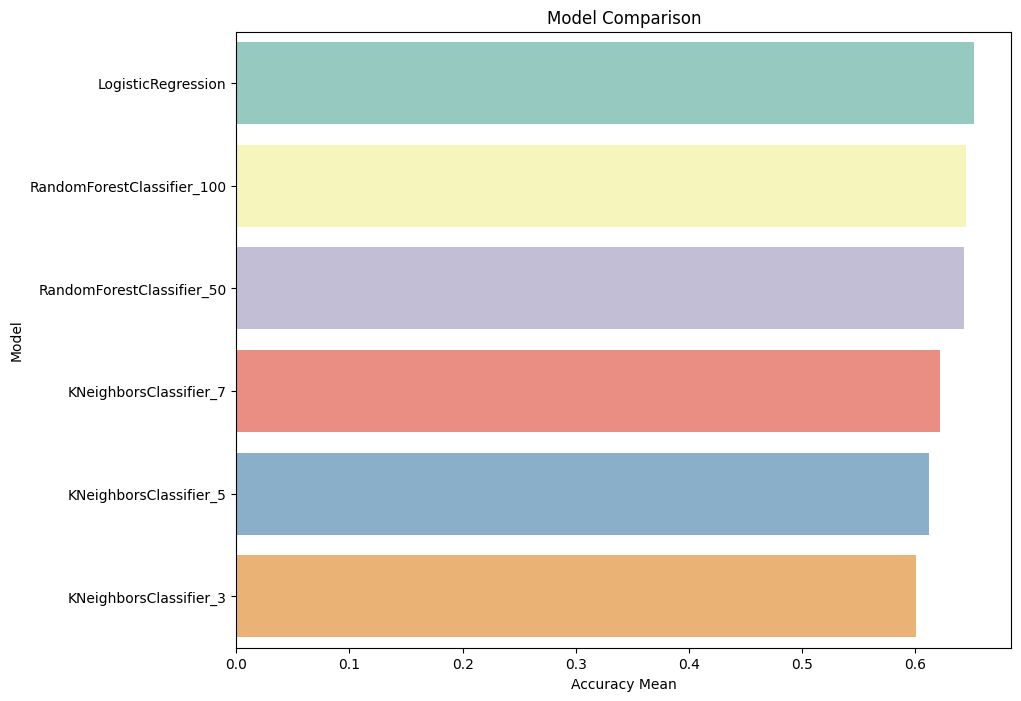

In [43]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Accuracy Mean', y='Model', data=results, palette='Set3')
plt.title('Model Comparison')

###
- Như vậy, ta có thể sơ bộ thấy mô hình logistic Reg cho kết quả tốt hơn các mô hình còn lại

### Classification Report

### 
- Đối với bài toán phân loại này, chúng ta cần quan tâm tới high Recall rating not_like.
- với high Recall cao, thì các True rating not-like phải cao, còn các False-not_like dự báo có thể cao hoặc thấp. 

### 
- Như vậy ta chon Logistic Regression cho việc tinh chỉnh mô hình tối ưu

### Logistic Regression

#### Hyperparameter tuning

In [44]:
# Use GridSearchCV to find the best parameters for the models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Create a list of parameters of Logistic Regression for the GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
#param_grid = {
    #'n_estimators': [100,300, 500, 1000],
    #'learning_rate':[0.001,0.01,0.1, 1]
#}
# Create a list of models to test
clf_grid = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1,cv=5, scoring='accuracy', error_score=0)
search_clf = clf_grid.fit(X_train, y_train)
best_clf = search_clf.best_estimator_

##Score
#cross_clf = cross_val_score(best_clf, X_test, y_test, scoring='accuracy', cv=5, n_jobs=-1)

In [45]:
print('Best params:', search_clf.best_params_)

Best params: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


### Best Params

In [46]:
## Create the best model
best_model = LogisticRegression(C= 100,penalty='l2',solver= 'newton-cg')
# Fit the best model to the training data
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

### Metrics to Report

In [47]:
# Get the accuracy score for the best model
accuracy_train = round(best_model.score(X_train, y_train) * 100, 3)
accuracy_test = round(best_model.score(X_test, y_test) * 100, 3)
print('Accuracy score for the best model on the training data: ', accuracy_train)
print('Accuracy score for the best model on the test data: ', accuracy_test)

Accuracy score for the best model on the training data:  65.274
Accuracy score for the best model on the test data:  64.979


              precision    recall  f1-score   support

    negative       0.49      0.61      0.55     41218
     neutral       0.36      0.01      0.03     24557
    positive       0.73      0.83      0.78     94234

    accuracy                           0.65    160009
   macro avg       0.53      0.49      0.45    160009
weighted avg       0.61      0.65      0.60    160009



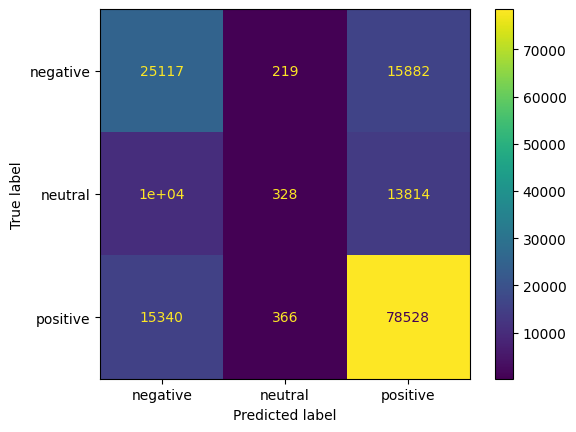

In [48]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred);

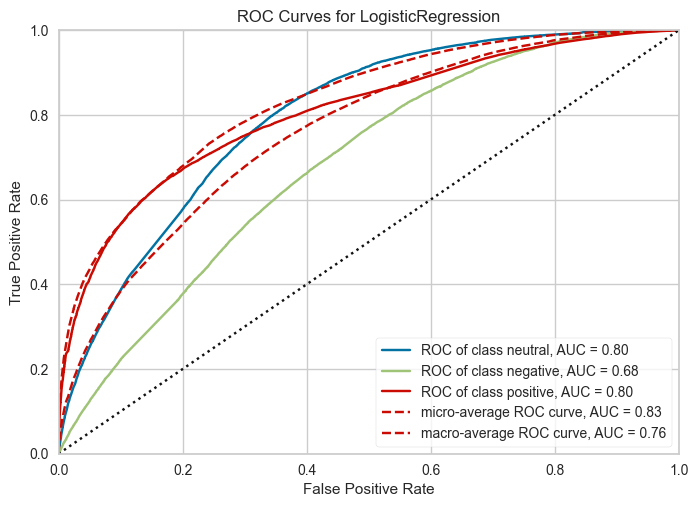

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [49]:
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, roc_auc
visualizer = ROCAUC(best_model, classes=y.unique())

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

### Nhận xét
- Mô hình 3 lớp cho phân loại kém, không caie thiện được nhiều
- do giới hạn về thời gian, tác giả sẽ tiếp tục với mô hình phân loại 2 lớp
- như đã nếu ở phần 1, các comment neutral vẫn có khả năng xếp vào nhóm khách hàng cần phải cải thiện.
- Nên thử mức độ tương đồng của 2 nhóm trên.